In [1]:
import numpy as np
import numpy.random as random
import random as r
from collections import OrderedDict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
stops = ["Służew", "Wierzbno", "Pole Mokotowskie", "Dworzec", "Rondo ONZ", 
           "Dworzec_2", "Pole Mokotowskie_2", "Wierzbno_2", "Służew_2"]

In [3]:
def f(cena=0):
    if cena <= 6:
        wspolczynnik = round(4/(1/2*cena+1)-1,3)
    else: 
        wspolczynnik = 0
    return wspolczynnik

In [4]:
def simulate_passengers(cena):
    passengers = {}
    for hour in range(24):
        passengers[hour] = {}
    for stop in stops:
        if stop != "Służew_2":
            wsp_ceny=f(cena)
            if stop == "Dworzec":
                number_passengers_in = random.gamma(6, 1.8, size=int(1200*wsp_ceny)).round(0)
                number_passengers_in = number_passengers_in[(number_passengers_in >=0) & \
                                                            (number_passengers_in <=23)]
                number_passengers_out = random.gamma(6, 1.9, size=int(1200*wsp_ceny)).round(0)
                number_passengers_out = number_passengers_out[(number_passengers_out >=0) & \
                                                              (number_passengers_out <=23)]
            elif '2' in stop:
                number_passengers_in = random.gamma(9, 1, size=int(400*wsp_ceny)).round(0).clip(0, 23)
                number_passengers_in = np.array([24-value for value in number_passengers_in])
                number_passengers_out = random.gamma(9, 1, size=int(800*wsp_ceny)).round(0).clip(0, 23)
                number_passengers_out = np.array([24-value for value in number_passengers_out])
            elif stop == "Rondo ONZ": 
                number_passengers_in = random.gamma(9, 1.2, size=int(1200*wsp_ceny)).round(0).clip(0, 23)
                number_passengers_in = np.array([24-value for value in number_passengers_in])
            else: 
                number_passengers_in = random.gamma(9, 1, size=int(800*wsp_ceny)).round(0).clip(0, 23)
                number_passengers_out = random.gamma(9, 1, size=int(400*wsp_ceny)).round(0).clip(0, 23)
            for hour in range(24):
                passengers[hour][stop] = {}
                passengers[hour][stop]["in"] = len(number_passengers_in[number_passengers_in == hour])
                if stop not in ["Służew", "Służew_2", "Rondo ONZ"]:
                    passengers[hour][stop]["out"] = len(number_passengers_out\
                                                              [number_passengers_out == hour])
    return passengers

In [5]:
cena_biletu = 2

In [6]:
simulate_passengers(cena_biletu)[0]

{'Służew': {'in': 0},
 'Wierzbno': {'in': 0, 'out': 0},
 'Pole Mokotowskie': {'in': 0, 'out': 0},
 'Dworzec': {'in': 0, 'out': 0},
 'Rondo ONZ': {'in': 0},
 'Dworzec_2': {'in': 0, 'out': 0},
 'Pole Mokotowskie_2': {'in': 0, 'out': 0},
 'Wierzbno_2': {'in': 0, 'out': 0}}

Text(0.5, 1.0, 'IN')

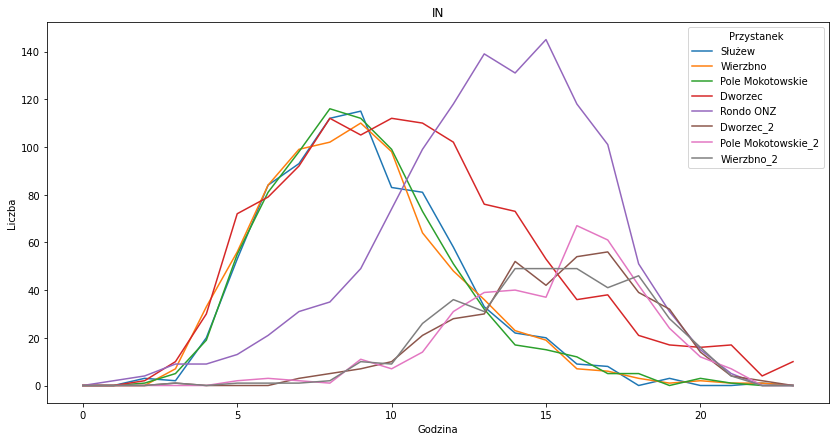

In [22]:
# Wykres dla 'IN'

lista_h = []
for h in range(0,24):
    lista = [h]*8
    lista_h += lista
stops = []
for i in range(0,24):
    s = ["Służew", "Wierzbno", "Pole Mokotowskie", "Dworzec", "Rondo ONZ", 
           "Dworzec_2", "Pole Mokotowskie_2", "Wierzbno_2"]
    stops += s
lista_pass = []
for key,value in simulate_passengers(cena_biletu).items():
    for k, v in value.items():
        lista_pass.append(v['in'])
df = pd.DataFrame({'Godzina': lista_h, 'Przystanek': stops, 'Liczba': lista_pass} )
fig, ax = plt.subplots(figsize=(14,7)) 
sns.lineplot(data=df,x='Godzina',y='Liczba',hue='Przystanek').set_title('IN')

Text(0.5, 1.0, 'OUT')

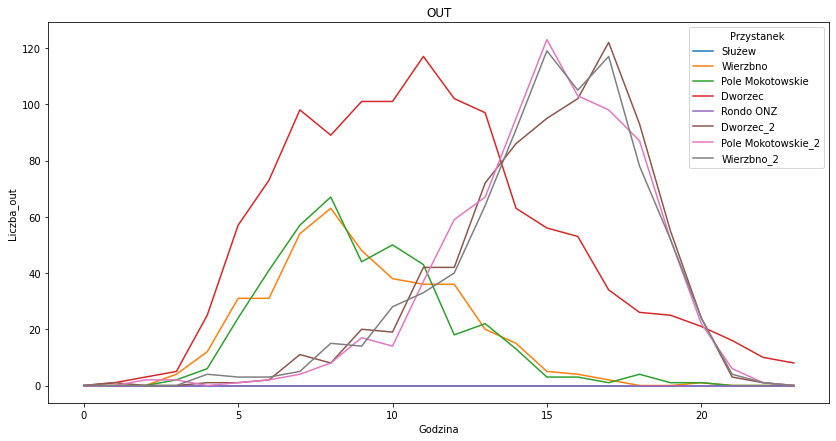

In [21]:
# Wykresy dla 'OUT'

lista_h = []
for h in range(0,24):
    lista = [h]*8
    lista_h += lista
stops = []

for i in range(0,24):
    s = ["Służew", "Wierzbno", "Pole Mokotowskie", "Dworzec", "Rondo ONZ", 
           "Dworzec_2", "Pole Mokotowskie_2", "Wierzbno_2"]
    stops += s
        
lista_pass_out = []
for key2,value2 in simulate_passengers(cena_biletu).items():
    for k2, v2 in value2.items():
        if 'out' not in v2:
            lista_pass_out.append(0)
        else:
            lista_pass_out.append(v2['out'])
df = pd.DataFrame({'Godzina': lista_h, 'Przystanek': stops, 'Liczba_out': lista_pass_out} )

fig, ax = plt.subplots(figsize=(14,7)) 
sns.lineplot(data=df,x='Godzina',y='Liczba_out',hue='Przystanek').set_title('OUT')

In [4]:
def random_times(n, num_terms = None):
    output = []
    mean = n/num_terms
    for time in range(num_terms):
        if time+1 == num_terms:
            output.append(n - sum(output))
        else:
            output.append(round(random.normal(mean, mean*0.1), 0))
    return output

In [5]:
def model(hour, stats, buses, capacity):
    # filtruje słownik z liczbą pasażerów (na daną godzine)
    stats_hour = stats[hour]
    # inicjuję potrzebne słowniki
    stats_stops = {}
    bus_passengers = {}
    for bus in range(buses):
        bus_passengers[bus+1] = {}
        bus_passengers[bus+1]['in'] = []
        bus_passengers[bus+1]['out'] = []
    # tworzę tuplę z listami wsiadających oraz wysiadających pasażerów z danego busa
    # długość list = liczba busów
    for key, value in stats_hour.items():
        if 'out' in value:
            stats_stops[key] = (random_times(value['in'], buses), random_times(value['out'], buses))
        else:
            stats_stops[key] = (random_times(value['in'], buses),)
    # inicjuję finalną listę z przewiezionymi pasażerami przez konkretne busy
    bus_output = []
    for bus in range(buses):
        # liczba aktualnych pasażerów w busie
        passengers = 0
        # liczba w sumie przewiezionych pasażerów
        passengers_final = 0
        for key, value in stats_stops.items():
            bus_passengers[bus+1]['in'].append(value[0][bus])
            if len(value) > 1:
                bus_passengers[bus+1]['out'].append(value[1][bus])
            else:
                bus_passengers[bus+1]['out'].append(0)
        for i in range(len(bus_passengers[bus+1]['in'])):
            # i == 4 to rondo onz, zakładamy, że na rondzie ONZ wysiądą wszyscy
            if i == 4:
                passengers = 0
            else:
                passengers -= min(bus_passengers[bus+1]['out'][i], passengers)
            passengers_final += min(capacity-passengers, bus_passengers[bus+1]['in'][i])
            passengers += min(capacity-passengers, bus_passengers[bus+1]['in'][i])
        bus_output.append(passengers_final)
    return  bus_output

In [108]:
cena_biletu = 1
hour = 9
stats = simulate_passengers(cena_biletu)
buses = 4
capacity = 40

627.0

In [6]:
def symulacja_init(iteration, cena_biletu, koszt_autobusu, list_buses, capacity):
    profits = []
    for i in range(iteration):
        profit = 0
        stats = simulate_passengers()
        for hour in range(24):
            passengers = model(hour, stats, list_buses[hour], capacity)
            profit += sum([value*cena_biletu for value in passengers])
            profit -= koszt_autobusu*list_buses[hour]
        profits.append(profit)
    return profits

In [7]:
def symulacja(iteration, cena_biletu, koszt_autobusu, buses, capacity):
    profits = []
    optimum_buses = []
    for i in range(iteration):
        profit = 0
        hour_bus = []
        stats = simulate_passengers(cena_biletu)
        for hour in range(24):
            hour_profit = []
            for bus in range(1, buses+1):
                passengers = model(hour, stats, bus, capacity)
                profit += sum([value*cena_biletu for value in passengers])
                profit -= koszt_autobusu*bus
                hour_profit.append(profit)
            hour_bus.append(hour_profit.index(max(hour_profit))+1)
            profit = max(hour_profit)
        profits.append(profit)
        optimum_buses.append(hour_bus)
    return profits #optimum_buses

In [10]:
def f(cena=0):
    if cena <= 4:
        wspolczynnik = round(-(0.33*cena)**2.4+2,3)
    else: 
        wspolczynnik = 0
    return wspolczynnik

In [105]:
ceny = [round(x * 0.1,2) for x in range(0, 70)]
ceny;

In [116]:
c = []
for cena in ceny:
    c.append(sum(model(hour, simulate_passengers(cena), buses, capacity)))

In [17]:
c = []
z = []
for i in ceny:
    print("Cena:", i,symulacja(1, i, 20, 2, 40))
    c.append(i)
    z.append(symulacja(1, i, 20, 2, 40))

Cena: 0.0 [-480.0]
Cena: 0.1 [-120.79999999999997]
Cena: 0.2 [568.2]
Cena: 0.3 [1411.3000000000004]
Cena: 0.4 [2245.1999999999994]
Cena: 0.5 [3171.0]
Cena: 0.6 [3976.2]
Cena: 0.7 [4836.799999999998]
Cena: 0.8 [5602.400000000001]
Cena: 0.9 [6534.6]
Cena: 1.0 [7365.0]
Cena: 1.1 [8196.199999999999]
Cena: 1.2 [8941.999999999996]
Cena: 1.3 [9678.400000000001]
Cena: 1.4 [10486.4]
Cena: 1.5 [11284.0]
Cena: 1.6 [11847.999999999998]
Cena: 1.7 [12566.499999999996]
Cena: 1.8 [13312.6]
Cena: 1.9 [13916.200000000003]
Cena: 2.0 [14592.0]
Cena: 2.1 [15280.6]
Cena: 2.2 [15886.6]
Cena: 2.3 [16128.7]
Cena: 2.4 [16396.000000000004]
Cena: 2.5 [16770.0]
Cena: 2.6 [17042.200000000008]
Cena: 2.7 [17333.8]
Cena: 2.8 [17158.000000000004]
Cena: 2.9 [17317.7]
Cena: 3.0 [17101.0]
Cena: 3.1 [16569.5]
Cena: 3.2 [16113.600000000002]
Cena: 3.3 [15672.1]
Cena: 3.4 [14525.799999999994]
Cena: 3.5 [13458.0]
Cena: 3.6 [11914.399999999998]
Cena: 3.7 [9814.900000000001]
Cena: 3.8 [7255.000000000001]
Cena: 3.9 [4096.19999999

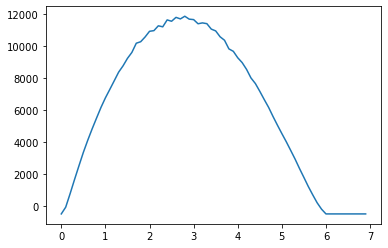

In [15]:
plt.plot(c, z)

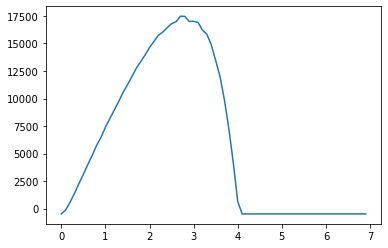

In [18]:
plt.plot(c, z)